In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import copy

# 是否用GPU计算，如果检测到有安装好的GPU，则利用它来计算
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

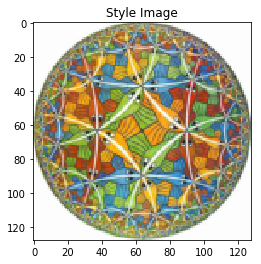

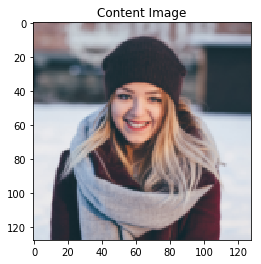

In [3]:
#风格图像的路径,自行设定
style = 'images/escher.jpg'

#内容图像的路径，自行设定
content = 'images/portrait1.jpg'

#风格损失所占比重
style_weight=1000

#内容损失所占比重
content_weight=1

#希望得到的图片大小（越大越清晰，计算越慢）
imsize = 128

loader = transforms.Compose([
    transforms.Resize(imsize),  # 将加载的图像转变为指定的大小
    transforms.ToTensor()])  # 将图像转化为tensor

#图片加载函数
def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # 为了适应卷积网络的需要，虚拟一个batch的维度
    image = image.unsqueeze(0)
    return image

#载入图片并检查尺寸
style_img = image_loader(style).type(dtype)
content_img = image_loader(content).type(dtype)

assert style_img.size() == content_img.size(), \
    "我们需要输入相同尺寸的风格和内容图像"

# 绘制图像的函数
def imshow(tensor, title=None):
    image = tensor.clone().cpu()  # 克隆Tensor防止改变
    image = image.view(3, imsize, imsize)  # 删除添加的batch层
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # 停一会以便更新视图

#绘制图片并查看
unloader = transforms.ToPILImage()  # 将其转化为PIL图像（Python Imaging Library） 
plt.ion()

plt.figure()
imshow(style_img.data, title='Style Image')

plt.figure()
imshow(content_img.data, title='Content Image')

In [4]:
cnn = models.vgg19(pretrained=True).features
# 如果有GPU就用GPU计算:
if use_cuda:
    cnn = cnn.cuda()

In [20]:
#内容损失模块
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # 由于网络的权重都是从target上迁移过来，所以在计算梯度的时候，需要把它和原始计算图分离
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        # 输入input为一个特征图
        # 它的功能就是计算误差，误差就是当前计算的内容与target之间的均方误差
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph=True):
        # 开始进行反向传播算法
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

class StyleLoss(nn.Module):

    # 计算风格损失的神经模块
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        #self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        # 输入input就是一个特征图
        self.output = input.clone()
        # 计算本图像的gram矩阵，并将它与target对比
        input = input.cuda() if use_cuda else input
        self_G = Gram(input)
        self_G.mul_(self.weight)
        # 计算损失函数，即输入特征图的gram矩阵与目标特征图的gram矩阵之间的差异
        self.loss = self.criterion(self_G, self.target)
        return self.output

    def backward(self, retain_graph=True):
        # 反向传播算法
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

#定义Gram矩阵
def Gram(input):
    # 输入一个特征图，计算gram矩阵
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=特征图的数量
    # (c,d)=特征图的图像尺寸 (N=c*d)

    features = input.view(a * b, c * d)  # 将特征图图像扁平化为一个向量

    G = torch.mm(features, features.t())  # 计算任意两个向量之间的乘积

    # 我们通过除以特征图中的像素数量来归一化特征图
    return G.div(a * b * c * d)

In [21]:
content_layers = ['conv_4'] #只考虑第四个卷积层的内容
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
# 我们要计算第1、2、3、4、5层的风格损失

In [22]:
# 定义列表存储每一个周期的计算损失
content_losses = []
style_losses = []

model = nn.Sequential()  # 一个新的序贯网络模型

# 如果有GPU就把这些计算挪到GPU上:
if use_cuda:
    model = model.cuda()

# 循环vgg的每一层，同时加入风格计算层和内容计算层，构造一个全新的神经网络model
# 将每层卷积核的数据都加载到新的网络模型model上来

i = 1
for layer in list(cnn):
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(i)
        #将已加载的模块放到model这个新的神经模块中
        model.add_module(name, layer)

        if name in content_layers:
            # 如果当前层模型在定义好的要计算内容的层:
            target = model(content_img).clone() #将内容图像当前层的feature信息拷贝到target中
            content_loss = ContentLoss(target, content_weight) #定义content_loss的目标函数
            content_loss = content_loss if use_cuda else content_loss
            model.add_module("content_loss_" + str(i), content_loss) #在新网络上加content_loss层
            content_losses.append(content_loss)

        if name in style_layers:
            # 如果当前层在指定的风格层中，进行风格层损失的计算
            target_feature = model(style_img).clone()
            target_feature = target_feature.cuda() if use_cuda else target_feature
            target_feature_gram = Gram(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            style_loss = style_loss.cuda() if use_cuda else style_loss
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

    if isinstance(layer, nn.ReLU):
        #如果不是卷积层，则做同样处理
        name = "relu_" + str(i)
        model.add_module(name, layer)

        i += 1

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(i)
        model.add_module(name, layer)

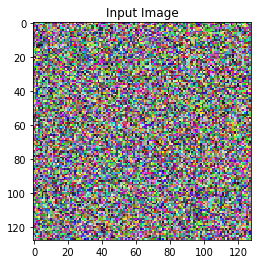

In [23]:
#原始输入图像，这里采用随机生成的噪音图
input_img = Variable(torch.randn(content_img.data.size())).type(dtype)

if use_cuda:
    input_img = input_img.cuda()
    content_img = content_img.cuda()
    style_img = style_img.cuda()
# 将选中的待调整图打印出来:
plt.figure()
imshow(input_img.data, title='Input Image')

正在构造风格迁移模型..
开始优化..
运行 0轮:
风格损失 : 2.759648 内容损失: 7.989360

运行 50轮:
风格损失 : 2.379823 内容损失: 7.526978

运行 100轮:
风格损失 : 1.982299 内容损失: 6.962901

运行 150轮:
风格损失 : 1.603008 内容损失: 6.537447

运行 200轮:
风格损失 : 1.337425 内容损失: 6.272446

运行 250轮:
风格损失 : 1.176713 内容损失: 6.102180



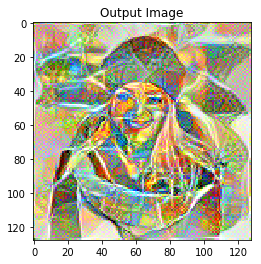

In [26]:
# 首先将输入图像变成神经网络的参数，这样我们就可以用反向传播算法来调节这个输入图像了
input_param = nn.Parameter(input_img.data)

#定义优化器，采用LBFGS优化算法来优化（试验效果很好，它的特点是可以计算大规模数据的梯度下降）
optimizer = optim.LBFGS([input_param])

# 迭代步数
num_steps=300


"""运行风格迁移的主算法过程."""
print('正在构造风格迁移模型..')

print('开始优化..')
for i in range(num_steps):
    #每一个训练周期

    # 限制输入图像的色彩取值范围在0-1间
    input_param.data.clamp_(0, 1)

    # 清空梯度
    optimizer.zero_grad()
    # 将图像输入构造的神经网络中
    model(input_param)
    style_score = 0
    content_score = 0

    # 每个损失函数层都开始反向传播算法
    for sl in style_losses:
        style_score += sl.backward()
    for cl in content_losses:
        content_score += cl.backward()

 # 每隔50个周期打印一次训练数据
    if i % 50 == 0:
        print("运行 {}轮:".format(i))
        print('风格损失 : {:4f} 内容损失: {:4f}'.format(
            style_score.data[0], content_score.data[0]))
        print()
    def closure():
        return style_score + content_score
    #一步优化
    optimizer.step(closure)

# 做一些修正，防止数据超界...
output = input_param.data.clamp_(0, 1)

# 打印结果图
plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()